In [18]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [79]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import segmentation_models as sm
import matplotlib
import imgaug.augmenters.contrast as iaa
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint

# Data preparation

In [80]:
images = list(Path(os.path.join('../data/unet/lung_segmentation/CXR_png/img')).glob('**/*'))
masks = list(Path(os.path.join('../data/unet/lung_segmentation/masks/img')).glob('**/*'))

In [81]:
print("Amount of images: ", len(images))
print("Amount of masks: ", len(masks))

Amount of images:  800
Amount of masks:  704


In [82]:
img_mask_tuples = []

for mask_path in masks:
    for i in images:
        basename = (os.path.basename(i)).split(".")[0]
        if basename in str(mask_path):
            img_path = i
            break
    img_mask_tuples.append((str(img_path), str(mask_path)))

In [83]:
len(img_mask_tuples)

704

## Plot images and masks

In [24]:
def plot_img(img_mask_tuple):
    img_concat = np.concatenate((cv2.imread(str(img_mask_tuple[0])), cv2.imread(str(img_mask_tuple[1]))), axis=1)
    plt.axis('off')
    plt.imshow(img_concat)

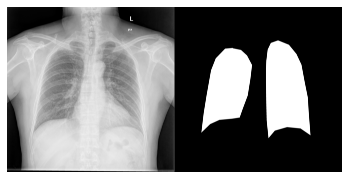

In [25]:
plot_img(img_mask_tuples[1])

In [26]:
def plot_img_matrix(img_mask_tuple_list, cols):
    # concat
    images = []
    for t in img_mask_tuple_list:
        img_concat = np.concatenate((cv2.imread(str(t[0])), cv2.imread(str(t[1]))), axis=1)
        images.append(img_concat)
    # plot
    plt.subplots(figsize=(15,5))
    if len(images) % cols == 0:
        rows = len(images) / cols
    else:
        rows = (len(images) % cols) +1
    for num, x in enumerate(images):
        plt.subplot(rows,cols,num+1)
        plt.axis('off')
        plt.imshow(x)

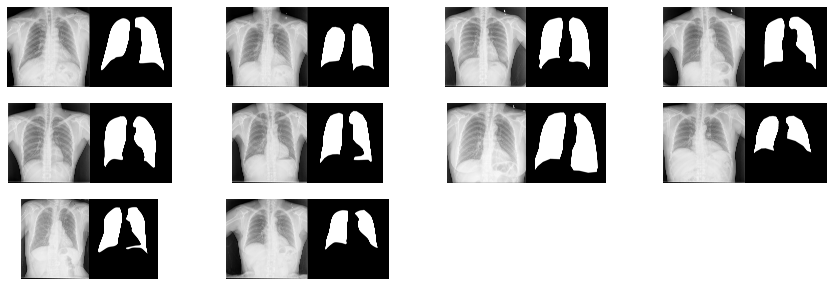

In [27]:
plot_img_matrix(img_mask_tuples[:10], 4)

In [28]:
df_train = pd.DataFrame(img_mask_tuples, dtype='str', columns=['img', 'mask'])
#train = df.sample(frac=0.8, random_state=200)
#test = df.drop(train.index)

In [103]:
pd.set_option('display.max_colwidth', -1)
df_train.head()

,img,mask
0,..\data\unet\lung_segmentation\CXR_png\img\CHNCXR_0001_0.png,..\data\unet\lung_segmentation\masks\img\CHNCXR_0001_0_mask.png
1,..\data\unet\lung_segmentation\CXR_png\img\CHNCXR_0002_0.png,..\data\unet\lung_segmentation\masks\img\CHNCXR_0002_0_mask.png
2,..\data\unet\lung_segmentation\CXR_png\img\CHNCXR_0003_0.png,..\data\unet\lung_segmentation\masks\img\CHNCXR_0003_0_mask.png
3,..\data\unet\lung_segmentation\CXR_png\img\CHNCXR_0004_0.png,..\data\unet\lung_segmentation\masks\img\CHNCXR_0004_0_mask.png
4,..\data\unet\lung_segmentation\CXR_png\img\CHNCXR_0005_0.png,..\data\unet\lung_segmentation\masks\img\CHNCXR_0005_0_mask.png


## UNET

In [104]:
# https://github.com/aleju/imgaug/issues/66#issuecomment-387609992
sigm_aug = iaa.SigmoidContrast(gain=(5, 5), cutoff=(0.8, 0.8))

In [105]:
def sigmoidcontrast(img):
    #rescale
    img = img/255.0
    img = sigm_aug.augment_image(img)
    return img

In [148]:
def binarize_mask(img):
    # specify a threshold 0-255
    threshold = 255 // 2
    # make all pixels < threshold black
    return 1.0 * (img > threshold)

In [154]:
def prep_img(img):
    return (img - 127.0) / 127.0 # its magic...

In [190]:
IMG_SIZE = 256

In [213]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=8, shuffle=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in indexes]
        X_img, X_mask = self.__get_data(batch)
        return np.array(X_img), np.array(X_mask)

    def on_epoch_end(self):
        # Todo: Fix?
        # self.indexes = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.indices)    

    def __get_data(self, batch):
        X_img_paths = self.df['img']
        X_mask_paths = self.df['mask']
        
        X_imgs = []
        X_masks = []

        for i in range(0, len(batch)):
            img = cv2.resize(cv2.imread(str(X_img_paths.iloc[batch[i]]), cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
            mask = cv2.resize(cv2.imread(str(X_mask_paths.iloc[batch[i]]), cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))

            mask = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)[1]
            # normalize / rescale

            img = img / 255.0
            mask = mask / 255.0

            X_imgs.append(img)
            X_masks.append(mask)

        return X_imgs, X_masks

In [214]:
# train_datagen = ImageDataGenerator(
#     # rescale=1./255,
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.1,
#     #preprocessing_function=sigmoidcontrast,
# )

# mask_datagen = ImageDataGenerator()

# img_generator = train_datagen.flow_from_dataframe(
#     dataframe= pd.DataFrame(df_train['img']), # masks
#     directory=None,
#     x_col="img",
#     y_col="img",
#     target_size=(256, 256),
#     color_mode = 'grayscale',
#     class_mode=None,
#     batch_size=8,
#     preprocessing_function=prep_img
# )

# mask_generator = train_datagen.flow_from_dataframe(
#     dataframe= pd.DataFrame(df_train['mask']), # masks
#     directory=None,
#     x_col="mask",
#     y_col="mask",
#     # color_mode = 'grayscale',
#     target_size=(256, 256),
#     class_mode=None,
#     batch_size=8,
#     preprocessing_function=binarize_mask
# )

# # https://github.com/keras-team/keras/issues/13123#issuecomment-529498919
# train_generator = (pair for pair in zip(img_generator, mask_generator))

In [215]:
train_generator = DataGenerator(df_train, batch_size=8)

In [216]:
train_generator.__getitem__(0)[1]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

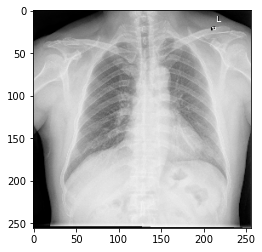

In [217]:
plt.imshow(train_generator.__getitem__(0)[0][0,:,:], cmap='gray')

In [218]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

In [223]:
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [224]:
model = unet()
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=2e-4),
    # loss=sm.losses.dice_loss,
    loss='binary_crossentropy',
    #loss=sm.losses.bce_dice_loss,
    metrics=['binary_accuracy', sm.metrics.iou_score],
)
model.summary()

Model: "functional_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_228 (Conv2D)             (None, 256, 256, 32) 320         input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_229 (Conv2D)             (None, 256, 256, 32) 9248        conv2d_228[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_48 (MaxPooling2D) (None, 128, 128, 32) 0           conv2d_229[0][0]                 
______________________________________________________________________________________

In [225]:
mcp_save = ModelCheckpoint('../models/unet_aws_2208.h5', save_best_only=True, monitor='iou_score', mode='max')

In [226]:
history = model.fit(train_generator, 
                    #validation_data=val_generator,
                    steps_per_epoch=len, 
                    #validation_steps=200,
                    epochs=5)
                    # callbacks=[mcp_save])

Epoch 1/5
88/88 [==============================] - 105s 1s/step - loss: 0.5519 - binary_accuracy: 0.7465 - iou_score: 0.1767
Epoch 2/5
88/88 [==============================] - 99s 1s/step - loss: 0.4000 - binary_accuracy: 0.7494 - iou_score: 0.2590
Epoch 3/5
88/88 [==============================] - 91s 1s/step - loss: 0.2390 - binary_accuracy: 0.9068 - iou_score: 0.5227
Epoch 4/5
88/88 [==============================] - 93s 1s/step - loss: 0.1130 - binary_accuracy: 0.9572 - iou_score: 0.7750
Epoch 5/5
88/88 [==============================] - 94s 1s/step - loss: 0.0913 - binary_accuracy: 0.9649 - iou_score: 0.8117


In [18]:
# model.save('../models/unet_aws_2208.h5')

In [227]:
chestx_train_normal_images = list(Path(os.path.join('../data/chest-x-ray/train/NORMAL')).glob('**/*'))
chestx_train_pneunomia_images = list(Path(os.path.join('../data/chest-x-ray/train/PNEUMONIA')).glob('**/*'))

chestx_train_normal_images_df = pd.DataFrame(chestx_train_normal_images, dtype='str', columns=['img'])
chestx_train_pneunomia_images_df = pd.DataFrame(chestx_train_pneunomia_images, dtype='str', columns=['img'])

chestx_val_normal_images = list(Path(os.path.join('../data/chest-x-ray/val/NORMAL')).glob('**/*'))
chestx_val_pneunomia_images = list(Path(os.path.join('../data/chest-x-ray/val/PNEUMONIA')).glob('**/*'))

chestx_val_normal_images_df = pd.DataFrame(chestx_val_normal_images, dtype='str', columns=['img'])
chestx_val_pneunomia_images_df = pd.DataFrame(chestx_val_pneunomia_images, dtype='str', columns=['img'])

In [232]:
pred_datagen = ImageDataGenerator(rescale=1. /255)

pred_normal_generator = pred_datagen.flow_from_dataframe(
    dataframe=chestx_train_normal_images_df,
    x_col='img',
    y_col='img',
    directory=None,
    color_mode='grayscale',
    target_size=(256, 256),
    class_mode=None,
    batch_size=8
)
pred_penumonia_generator = pred_datagen.flow_from_dataframe(
    dataframe=chestx_train_pneunomia_images_df,
    x_col='img',
    y_col='img',
    directory=None,
    color_mode='grayscale',
    target_size=(256, 256),
    class_mode=None,
    batch_size=8
)

Found 1341 validated image filenames.
Found 3875 validated image filenames.


In [229]:
pred_penumonia_generator.__getitem__(0)[0]

array([[[21.],
        [21.],
        [20.],
        ...,
        [31.],
        [30.],
        [32.]],

       [[21.],
        [21.],
        [21.],
        ...,
        [29.],
        [30.],
        [31.]],

       [[21.],
        [21.],
        [22.],
        ...,
        [27.],
        [29.],
        [30.]],

       ...,

       [[12.],
        [ 6.],
        [13.],
        ...,
        [26.],
        [ 6.],
        [ 2.]],

       [[21.],
        [15.],
        [13.],
        ...,
        [27.],
        [18.],
        [14.]],

       [[14.],
        [10.],
        [13.],
        ...,
        [28.],
        [ 9.],
        [ 3.]]], dtype=float32)

In [233]:
chestx_normal_pred_masks = model.predict(pred_normal_generator)

In [181]:
chestx_penumonia_pred_masks = model.predict(pred_penumonia_generator)

In [168]:
def save_pred_masks(df, pred_masks, path):
    for i in range(0,len(pred_masks)):
        org_img = df.iloc[i][0]
        pred_mask_name = os.path.basename(org_img).split('.')[0] + '_predmask.jpg'

        mask = binarize_mask(pred_masks[i] * 255)

        plt.imsave(path + pred_mask_name, mask[:,:,0], cmap='gray')

In [234]:
save_pred_masks(chestx_train_pneunomia_images_df, chestx_penumonia_pred_masks, '../data/chest-x-ray/masks/train/PNEUMONIA/')

In [13]:
save_pred_masks(chestx_train_normal_images_df, chestx_normal_pred_masks, '../data/chest-x-ray/masks/val/NORMAL/')